In [1]:
# Document Processing Pipeline - Complete System
# This notebook processes invoices from image/PDF to structured text extraction

import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

# Import our custom modules
from src.ingestion.document_loader import DocumentLoader
from src.preprocessing.image_preprocessor import ImagePreprocessor
from src.ocr.ocr_engine import OCREngine

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

print("✅ All modules imported successfully!")
print("📦 Available modules:")
print("   - DocumentLoader: Load PDFs and images")
print("   - ImagePreprocessor: Clean and enhance images")
print("   - OCREngine: Extract text from images")


✅ All modules imported successfully!
📦 Available modules:
   - DocumentLoader: Load PDFs and images
   - ImagePreprocessor: Clean and enhance images
   - OCREngine: Extract text from images


In [2]:
# ═══════════════════════════════════════════════════════════════════
# CONFIGURATION - Set your document path here
# ═══════════════════════════════════════════════════════════════════

# Change this to your document path
DOCUMENT_PATH = 'sample_documents/invoice_dataset/image/001.png'

# Pipeline settings
DPI = 300  # Resolution for PDF conversion
ENABLE_DESKEW = True  # Enable rotation correction
OCR_LANGUAGES = ['en']  # Languages for OCR (English)
USE_GPU = False  # Set to True if you have GPU

print(f"📄 Target Document: {DOCUMENT_PATH}")
print(f"⚙️  Settings: DPI={DPI}, Deskew={ENABLE_DESKEW}, Languages={OCR_LANGUAGES}")


📄 Target Document: sample_documents/invoice_dataset/image/001.png
⚙️  Settings: DPI=300, Deskew=True, Languages=['en']


STAGE 1: DOCUMENT INGESTION

📄 Document Information:
   Filename: 001.png
   Format: .png
   Size: 0.19 MB

📥 Loading document...
✓ Successfully loaded 1 page(s)
   Page 1: 1653x2339 pixels (3.9MP) - RGB mode


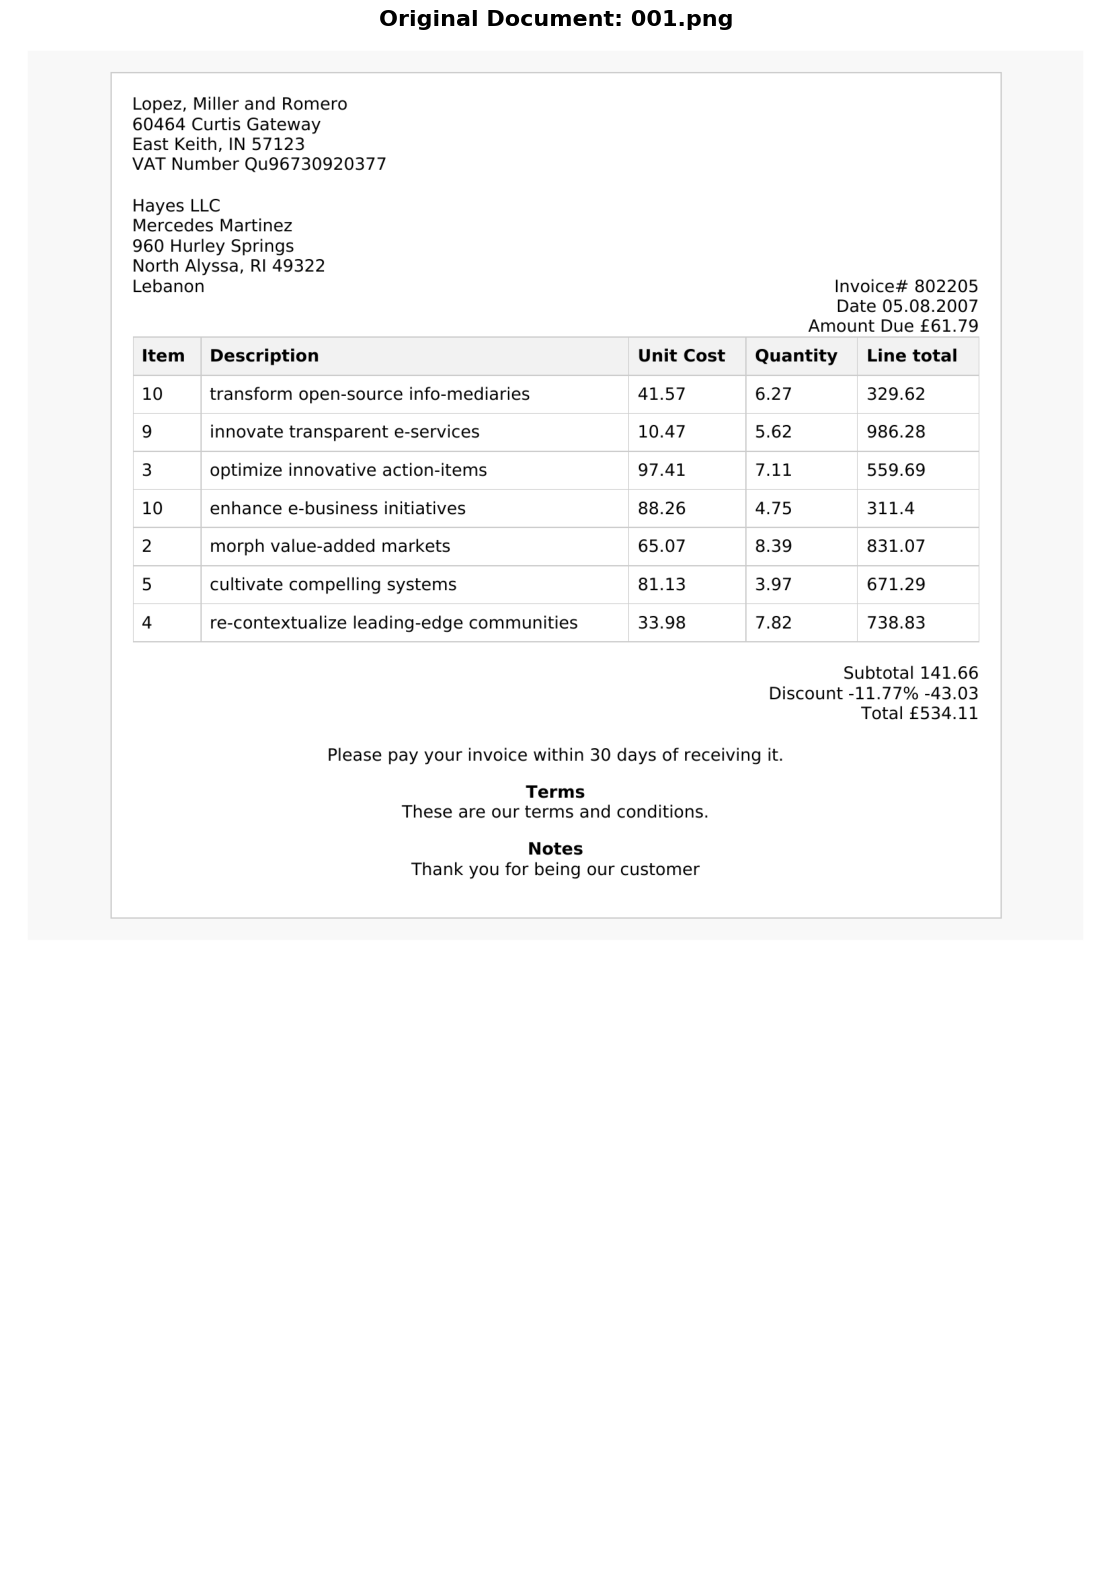


✅ Stage 1 Complete!


In [3]:
# ═══════════════════════════════════════════════════════════════════
# STAGE 1: DOCUMENT INGESTION
# Load PDF or image files and convert to standard format
# ═══════════════════════════════════════════════════════════════════

print("="*60)
print("STAGE 1: DOCUMENT INGESTION")
print("="*60)

# Initialize loader
loader = DocumentLoader(dpi=DPI)

# Get document information
info = loader.get_document_info(DOCUMENT_PATH)
print(f"\n📄 Document Information:")
print(f"   Filename: {info['filename']}")
print(f"   Format: {info['format']}")
print(f"   Size: {info['size_mb']} MB")

# Load document
print(f"\n📥 Loading document...")
images = loader.load(DOCUMENT_PATH)
print(f"✓ Successfully loaded {len(images)} page(s)")

# Display page details
for i, img in enumerate(images, 1):
    width, height = img.size
    megapixels = (width * height) / 1_000_000
    print(f"   Page {i}: {width}x{height} pixels ({megapixels:.1f}MP) - {img.mode} mode")

# Display the original document
plt.figure(figsize=(12, 16))
plt.imshow(images[0])
plt.title(f"Original Document: {info['filename']}", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Stage 1 Complete!")


STAGE 2: PREPROCESSING

🧹 Preprocessing 1 page(s)...
   ✓ Page 1 preprocessed (deskewed, denoised, enhanced, binarized)


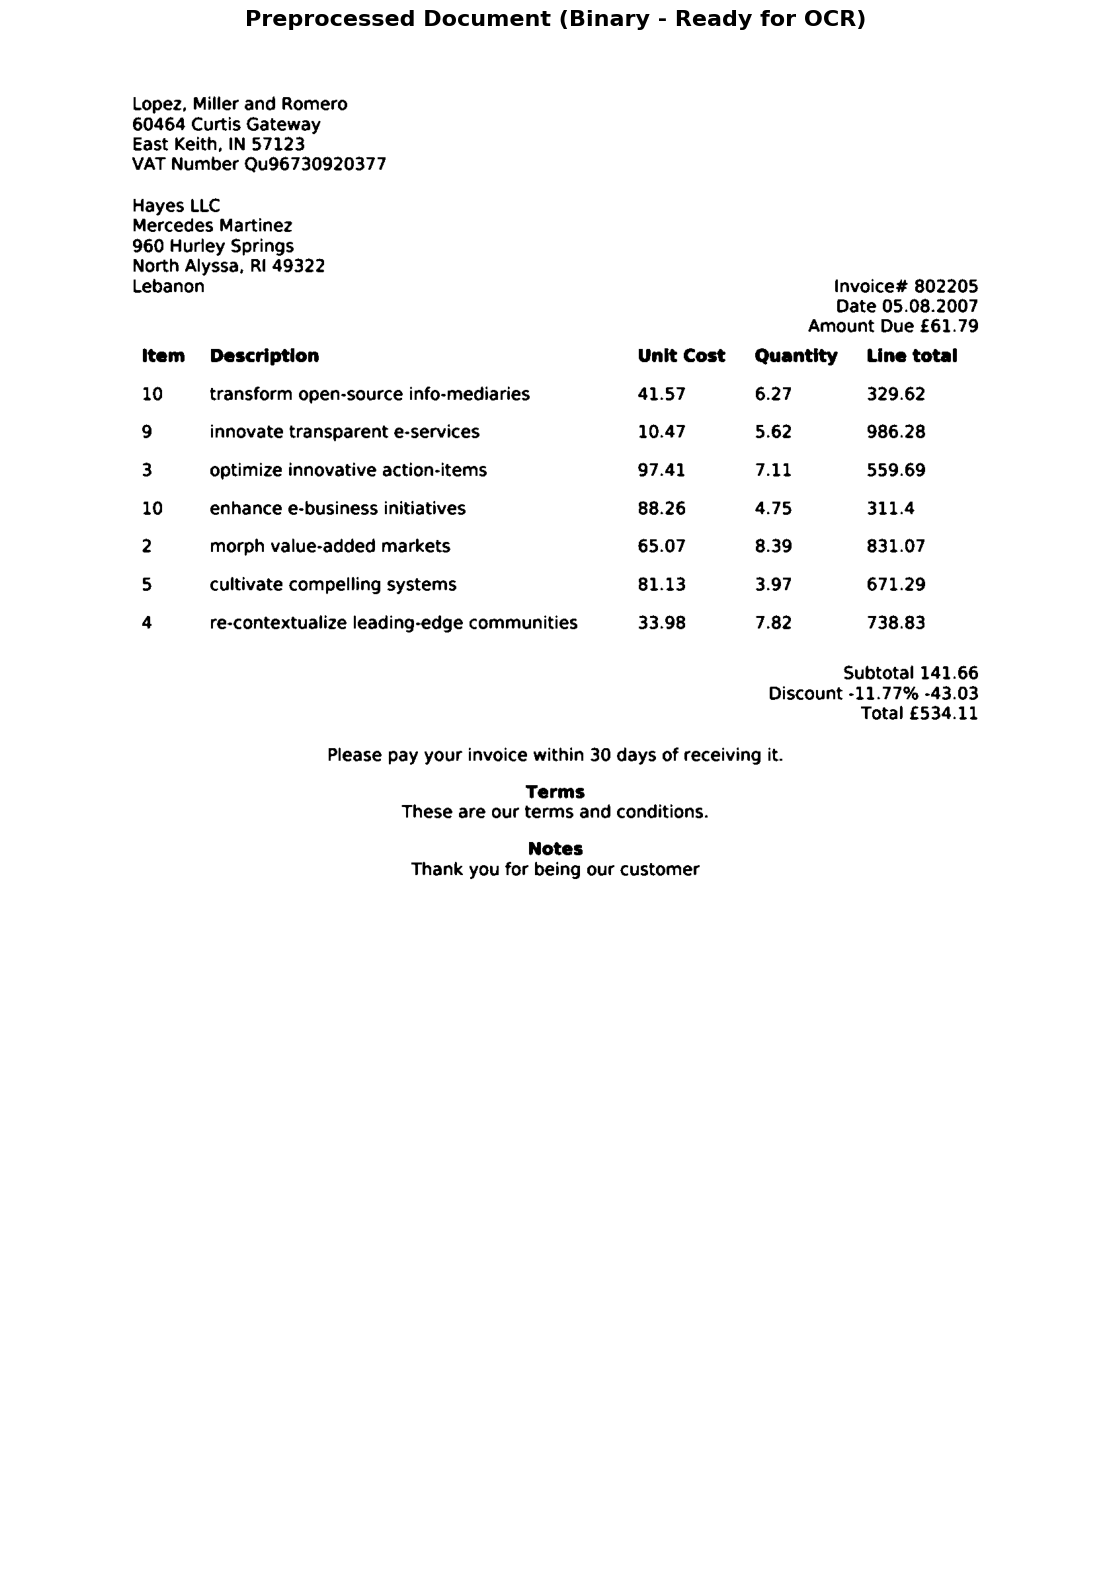


✅ Stage 2 Complete!


In [4]:
# ═══════════════════════════════════════════════════════════════════
# STAGE 2: PREPROCESSING
# Clean and enhance images for optimal OCR performance
# ═══════════════════════════════════════════════════════════════════

print("="*60)
print("STAGE 2: PREPROCESSING")
print("="*60)

# Initialize preprocessor
preprocessor = ImagePreprocessor(target_dpi=DPI)

# Preprocess all pages
processed_images = []
print(f"\n🧹 Preprocessing {len(images)} page(s)...")
for i, img in enumerate(images, 1):
    processed = preprocessor.preprocess(img, enable_deskew=ENABLE_DESKEW)
    processed_images.append(processed)
    print(f"   ✓ Page {i} preprocessed (deskewed, denoised, enhanced, binarized)")

# Display preprocessed image
plt.figure(figsize=(12, 16))
plt.imshow(processed_images[0], cmap='gray')
plt.title("Preprocessed Document (Binary - Ready for OCR)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Stage 2 Complete!")


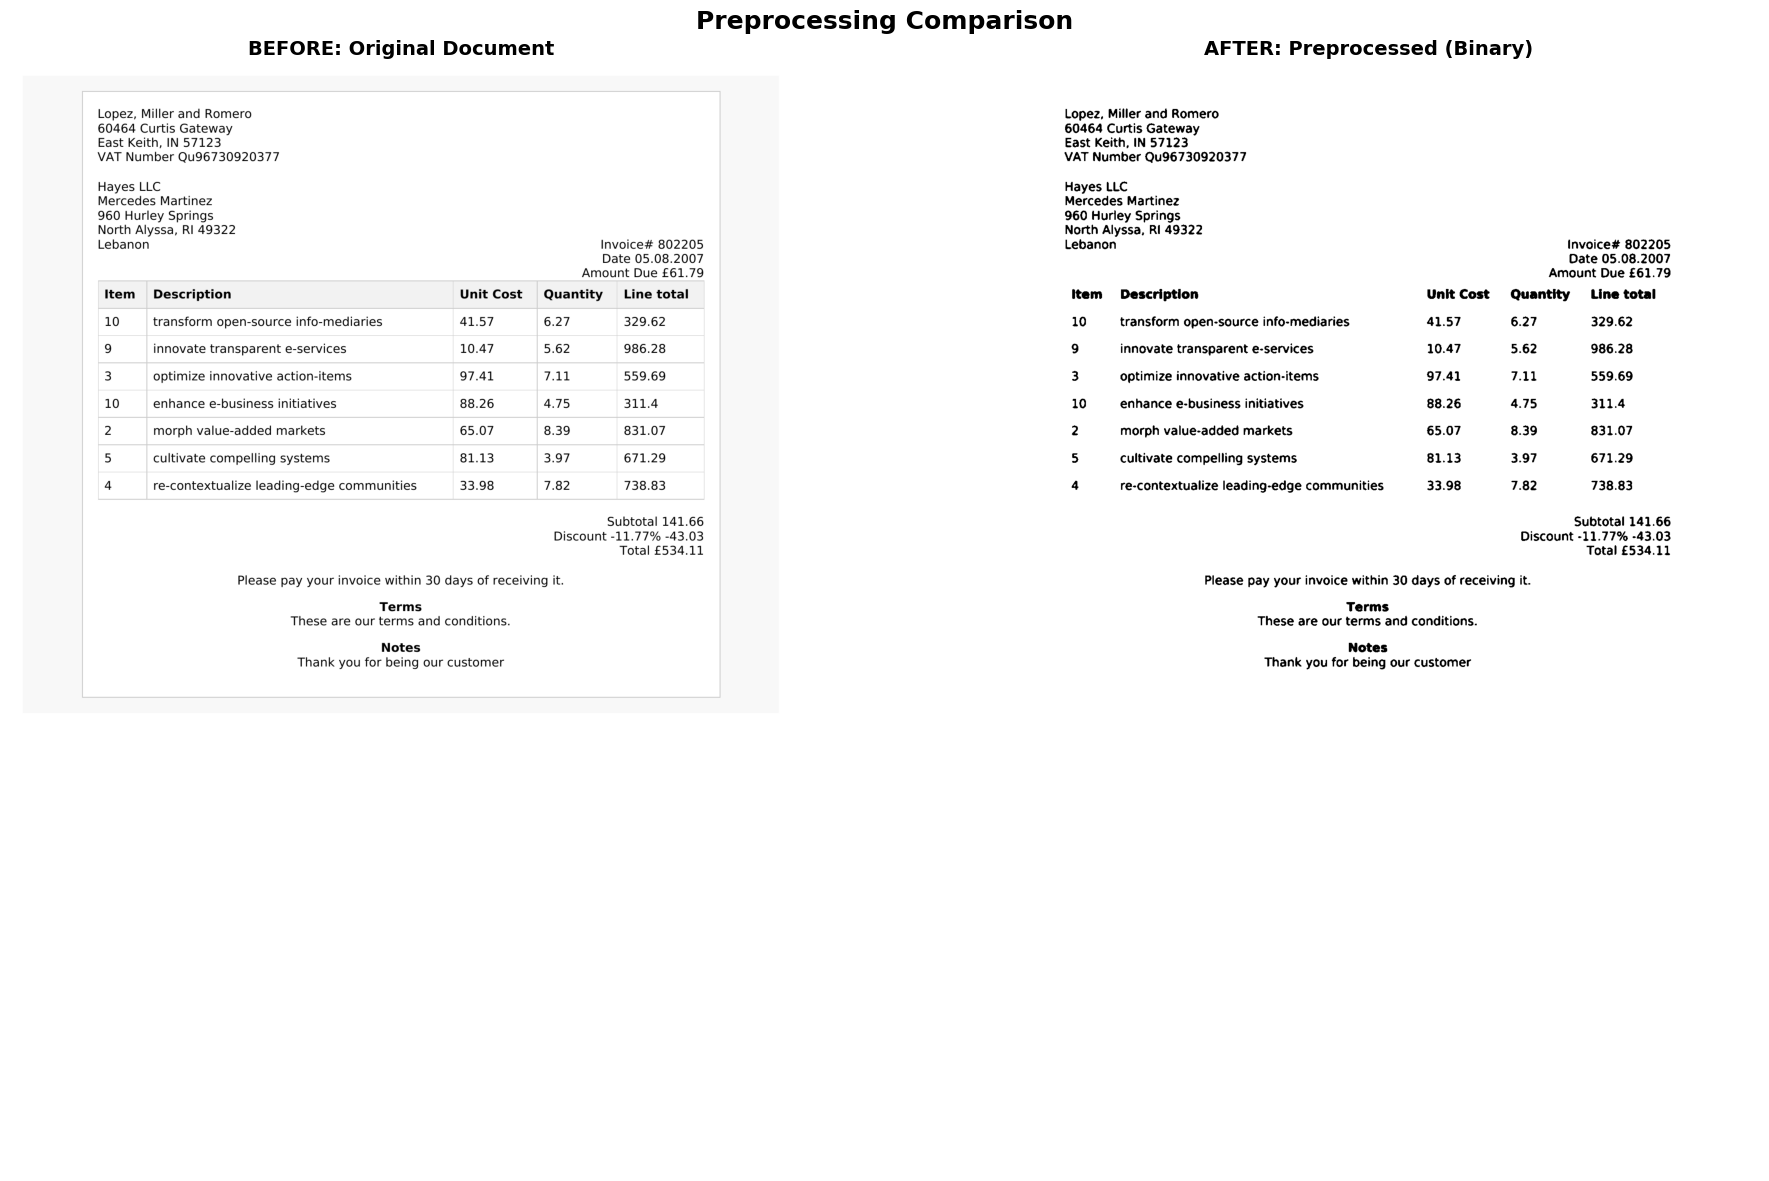

📊 Key improvements:
   ✓ Background noise removed
   ✓ Text contrast enhanced
   ✓ Black text on white background (optimal for OCR)
   ✓ Any rotation corrected


In [5]:
# ═══════════════════════════════════════════════════════════════════
# COMPARISON: Before vs After Preprocessing
# ═══════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Original
axes[0].imshow(images[0])
axes[0].set_title("BEFORE: Original Document", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Preprocessed
axes[1].imshow(processed_images[0], cmap='gray')
axes[1].set_title("AFTER: Preprocessed (Binary)", fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle("Preprocessing Comparison", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("📊 Key improvements:")
print("   ✓ Background noise removed")
print("   ✓ Text contrast enhanced")
print("   ✓ Black text on white background (optimal for OCR)")
print("   ✓ Any rotation corrected")


In [6]:
# ═══════════════════════════════════════════════════════════════════
# STAGE 3: OCR (Optical Character Recognition)
# Extract text from preprocessed images
# ═══════════════════════════════════════════════════════════════════

print("="*60)
print("STAGE 3: OCR TEXT EXTRACTION")
print("="*60)

# Initialize OCR engine
print(f"\n📖 Initializing EasyOCR for languages: {OCR_LANGUAGES}...")
ocr = OCREngine(languages=OCR_LANGUAGES, gpu=USE_GPU)

# Extract text from all pages
ocr_results = []
print(f"\n🔍 Extracting text from {len(processed_images)} page(s)...")
for i, img in enumerate(processed_images, 1):
    text_data = ocr.extract_text(img)
    ocr_results.append(text_data)
    
    num_blocks = len(text_data)
    total_chars = sum(len(block['text']) for block in text_data)
    avg_confidence = sum(block['confidence'] for block in text_data) / num_blocks if num_blocks > 0 else 0
    
    print(f"   ✓ Page {i}: Found {num_blocks} text blocks, {total_chars} characters, avg confidence: {avg_confidence:.2f}")

print(f"\n✅ Stage 3 Complete!")


Using CPU. Note: This module is much faster with a GPU.


STAGE 3: OCR TEXT EXTRACTION

📖 Initializing EasyOCR for languages: ['en']...
Initializing EasyOCR for languages: ['en']...
✓ OCR engine ready

🔍 Extracting text from 1 page(s)...
   ✓ Page 1: Found 59 text blocks, 768 characters, avg confidence: 0.93

✅ Stage 3 Complete!


In [7]:
# ═══════════════════════════════════════════════════════════════════
# DISPLAY: Extracted Text with Confidence Scores
# ═══════════════════════════════════════════════════════════════════

print("="*80)
print("EXTRACTED TEXT (Sorted by position)")
print("="*80)

for page_num, page_data in enumerate(ocr_results, 1):
    if len(ocr_results) > 1:
        print(f"\n--- PAGE {page_num} ---\n")
    
    # Sort by Y position (top to bottom) for better reading order
    sorted_blocks = sorted(page_data, key=lambda x: x['bbox'][0][1])
    
    # Display text blocks with confidence indicators
    for i, block in enumerate(sorted_blocks, 1):
        text = block['text']
        confidence = block['confidence']
        
        # Confidence indicator
        if confidence >= 0.9:
            indicator = "✓"  # High confidence
        elif confidence >= 0.7:
            indicator = "~"  # Medium confidence
        else:
            indicator = "?"  # Low confidence
        
        print(f"{i:3d}. [{indicator} {confidence:.2f}] {text}")

print("\n" + "="*80)
print("Legend: ✓ = High confidence (≥0.9)  ~ = Medium (0.7-0.9)  ? = Low (<0.7)")
print("="*80)


EXTRACTED TEXT (Sorted by position)
  1. [✓ 0.95] Lopez, Miller and Romero
  2. [✓ 1.00] 60464 Curtis Gateway
  3. [✓ 0.97] East Keith, IN 57123
  4. [✓ 1.00] VAT Number Qu96730920377
  5. [~ 0.89] Hayes LLC
  6. [✓ 1.00] Mercedes Martinez
  7. [~ 0.83] 960 Hurley Springs
  8. [✓ 0.94] North Alyssa, RI 49322
  9. [✓ 1.00] Invoice# 802205
 10. [✓ 1.00] Lebanon
 11. [✓ 0.95] Date 05.08.2007
 12. [~ 0.79] Amount Due E61.79
 13. [~ 0.83] Descriptlon
 14. [? 0.69] Quantlty
 15. [✓ 0.99] Unlt Cost
 16. [✓ 0.99] Item
 17. [~ 0.84] Line total
 18. [~ 0.80] transform open-source info-mediaries
 19. [✓ 1.00] 10
 20. [✓ 1.00] 329.62
 21. [? 0.65] 41.57
 22. [✓ 1.00] 6.27
 23. [✓ 0.92] innovate transparent e-services
 24. [✓ 0.92] 10.47
 25. [✓ 0.94] 5.62
 26. [✓ 1.00] 986.28
 27. [✓ 1.00] 9
 28. [✓ 1.00] 559.69
 29. [✓ 0.99] optimize innovative action-items
 30. [✓ 0.95] 97.41
 31. [✓ 1.00] 3
 32. [✓ 1.00] 7.11
 33. [✓ 1.00] 10
 34. [✓ 0.99] enhance e-business initiatives
 35. [✓ 1.00] 88.26
 36.

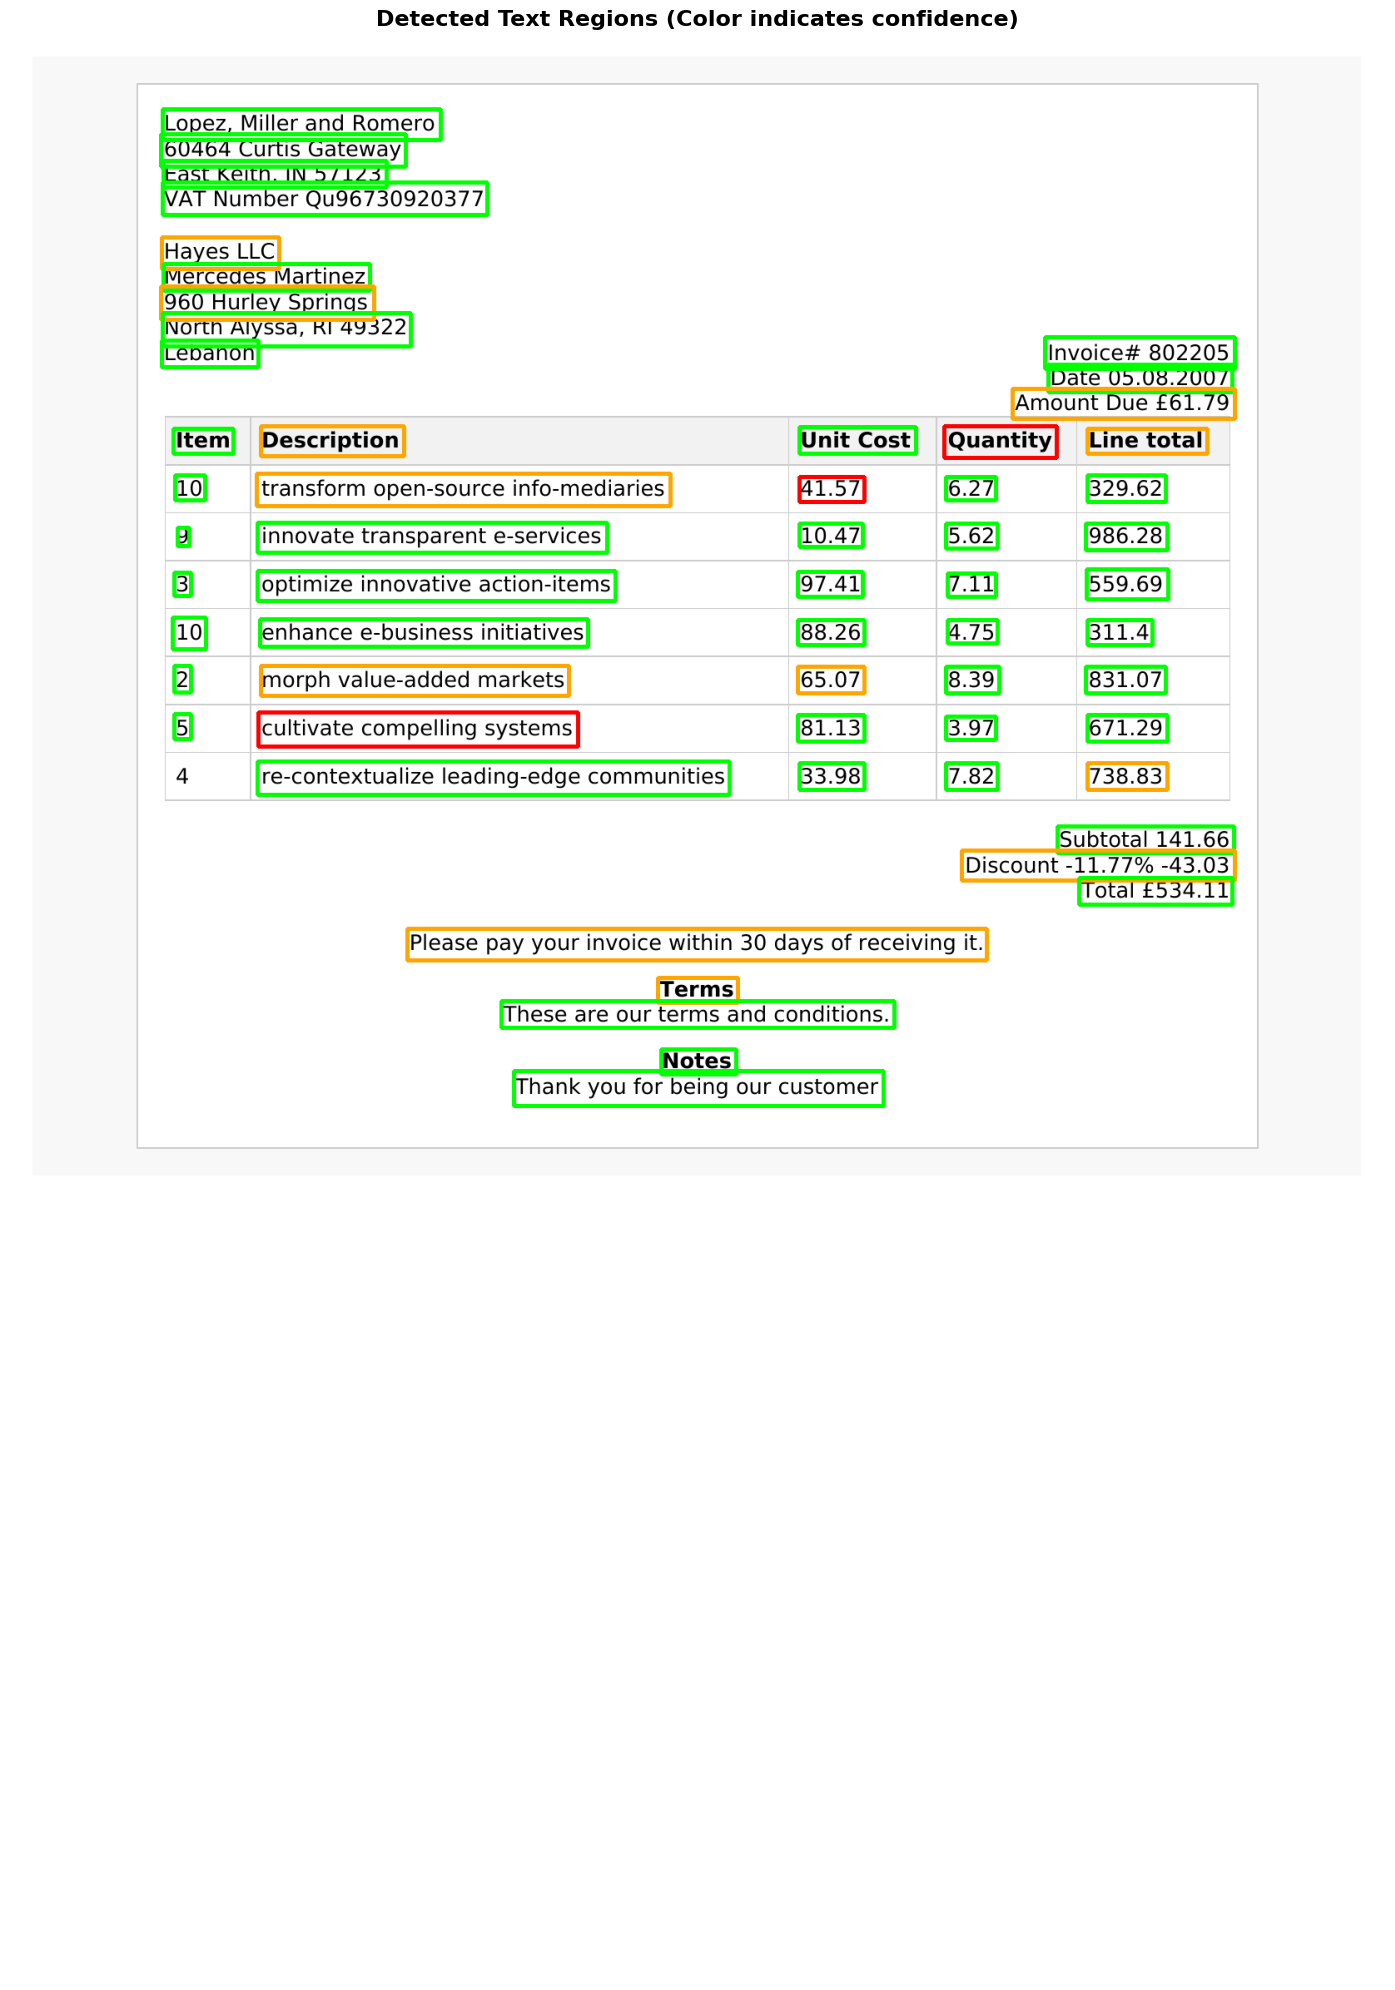

📊 Visualization shows bounding boxes around each detected text block
   Color coding helps identify which text may need manual review


In [8]:
# ═══════════════════════════════════════════════════════════════════
# VISUALIZATION: Text Regions with Bounding Boxes
# Color-coded by confidence level
# ═══════════════════════════════════════════════════════════════════

# Create a copy of the original image for annotation
display_img = np.array(images[0].copy())

# Draw bounding boxes for each detected text block
for block in ocr_results[0]:
    bbox = block['bbox']
    confidence = block['confidence']
    
    # Color based on confidence level
    if confidence >= 0.9:
        color = (0, 255, 0)  # Green - High confidence
    elif confidence >= 0.7:
        color = (255, 165, 0)  # Orange - Medium confidence
    else:
        color = (255, 0, 0)  # Red - Low confidence
    
    # Draw polygon around text
    pts = np.array(bbox, dtype=np.int32)
    cv2.polylines(display_img, [pts], True, color, 3)

# Display annotated image
plt.figure(figsize=(15, 20))
plt.imshow(display_img)
plt.title("Detected Text Regions (Color indicates confidence)", fontsize=16, fontweight='bold')
plt.xlabel("Green = High confidence  |  Orange = Medium  |  Red = Low", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

print("📊 Visualization shows bounding boxes around each detected text block")
print("   Color coding helps identify which text may need manual review")


📊 PROCESSING STATISTICS

📄 Document:
   File: 001.png
   Pages processed: 1

📝 Text Extraction:
   Total text blocks: 59
   Total characters: 768
   Average confidence: 0.931 (93.1%)

✓ Confidence Distribution:
   High (≥0.9): 44 blocks (74.6%)
   Medium (0.7-0.9): 12 blocks (20.3%)
   Low (<0.7): 3 blocks (5.1%)


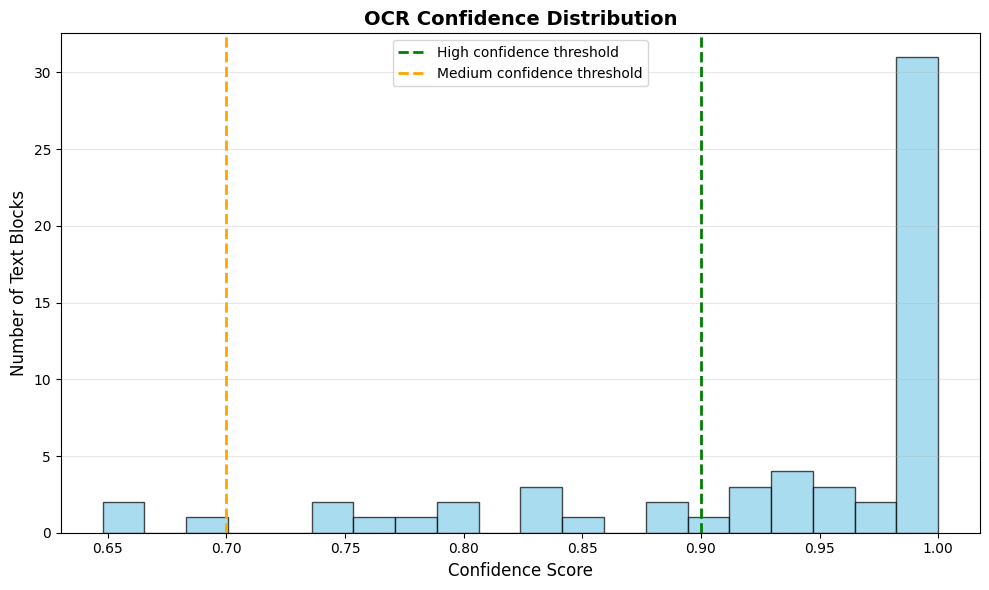


✅ PIPELINE COMPLETE!

📋 Completed Stages:
   [✓] Stage 1: Document Ingestion
   [✓] Stage 2: Preprocessing
   [✓] Stage 3: OCR Text Extraction

⏳ Next Steps:
   [ ] Stage 4: Field Extraction (identify invoice fields)
   [ ] Stage 5: Validation & JSON Export


In [9]:
# ═══════════════════════════════════════════════════════════════════
# STATISTICS & SUMMARY
# ═══════════════════════════════════════════════════════════════════

print("="*80)
print("📊 PROCESSING STATISTICS")
print("="*80)

# Calculate statistics
total_pages = len(ocr_results)
total_blocks = sum(len(page) for page in ocr_results)
total_chars = sum(sum(len(block['text']) for block in page) for page in ocr_results)

all_confidences = [block['confidence'] for page in ocr_results for block in page]
avg_confidence = sum(all_confidences) / len(all_confidences) if all_confidences else 0

high_conf = sum(1 for c in all_confidences if c >= 0.9)
med_conf = sum(1 for c in all_confidences if 0.7 <= c < 0.9)
low_conf = sum(1 for c in all_confidences if c < 0.7)

print(f"\n📄 Document:")
print(f"   File: {info['filename']}")
print(f"   Pages processed: {total_pages}")

print(f"\n📝 Text Extraction:")
print(f"   Total text blocks: {total_blocks}")
print(f"   Total characters: {total_chars}")
print(f"   Average confidence: {avg_confidence:.3f} ({avg_confidence*100:.1f}%)")

print(f"\n✓ Confidence Distribution:")
print(f"   High (≥0.9): {high_conf} blocks ({high_conf/total_blocks*100:.1f}%)")
print(f"   Medium (0.7-0.9): {med_conf} blocks ({med_conf/total_blocks*100:.1f}%)")
print(f"   Low (<0.7): {low_conf} blocks ({low_conf/total_blocks*100:.1f}%)")

# Visualize confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(all_confidences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0.9, color='green', linestyle='--', linewidth=2, label='High confidence threshold')
plt.axvline(0.7, color='orange', linestyle='--', linewidth=2, label='Medium confidence threshold')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Number of Text Blocks', fontsize=12)
plt.title('OCR Confidence Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ PIPELINE COMPLETE!")
print("="*80)

print(f"\n📋 Completed Stages:")
print(f"   [✓] Stage 1: Document Ingestion")
print(f"   [✓] Stage 2: Preprocessing")
print(f"   [✓] Stage 3: OCR Text Extraction")
print(f"\n⏳ Next Steps:")
print(f"   [ ] Stage 4: Field Extraction (identify invoice fields)")
print(f"   [ ] Stage 5: Validation & JSON Export")


## Stage 4: Field Extraction

Extract structured fields from OCR text (invoice number, date, amounts, vendor)


In [10]:
# FIELD EXTRACTION: Identify and extract structured fields
from src.extraction.field_extractor import FieldExtractor

print("🔍 Extracting structured fields...")
extractor = FieldExtractor()

# Extract fields from first page
fields = extractor.extract_all_fields(ocr_results[0])
formatted_fields = extractor.format_output(fields)

print(f"✓ Extracted {len([k for k, v in formatted_fields.items() if v])} fields\n")

# Display extracted fields
print("=" * 70)
print("📋 STRUCTURED DATA EXTRACTED:")
print("=" * 70)

if formatted_fields.get('invoice_number'):
    print(f"  📄 Invoice Number: {formatted_fields['invoice_number']}")

if formatted_fields.get('date'):
    print(f"  📅 Date: {formatted_fields['date']}")

if formatted_fields.get('vendor'):
    print(f"  🏢 Vendor: {formatted_fields['vendor']}")

if formatted_fields.get('total'):
    total_data = formatted_fields['total']
    print(f"  💰 Total: ${total_data['amount']:.2f}")
    print(f"     └─ Confidence: {total_data['confidence']:.2%}")

if formatted_fields.get('subtotal'):
    subtotal_data = formatted_fields['subtotal']
    print(f"  📊 Subtotal: ${subtotal_data['amount']:.2f}")
    print(f"     └─ Confidence: {subtotal_data['confidence']:.2%}")

if formatted_fields.get('tax'):
    tax_data = formatted_fields['tax']
    print(f"  🧾 Tax: ${tax_data['amount']:.2f}")
    print(f"     └─ Confidence: {tax_data['confidence']:.2%}")

if formatted_fields.get('all_amounts'):
    print(f"\n  💵 All amounts found: {len(formatted_fields['all_amounts'])}")
    print(f"     └─ {formatted_fields['all_amounts'][:10]}")  # Show first 10

print("=" * 70)


🔍 Extracting structured fields...
✓ Extracted 7 fields

📋 STRUCTURED DATA EXTRACTED:
  📄 Invoice Number: 802205
  📅 Date: 05.08.2007
  🏢 Vendor: Lopez, Miller and Romero
  💰 Total: $141.66
     └─ Confidence: 99.66%
  📊 Subtotal: $141.66
     └─ Confidence: 99.66%
  🧾 Tax: $10.47
     └─ Confidence: 91.80%

  💵 All amounts found: 23
     └─ [5.08, 41.57, 6.27, 329.62, 10.47, 5.62, 986.28, 97.41, 7.11, 559.69]


## Stage 5: Data Validation

Validate extracted fields and check data quality


In [11]:
# DATA VALIDATION: Check data quality and consistency
from src.validation.data_validator import DataValidator

print("✅ Validating extracted data...")
validator = DataValidator(min_confidence=0.7)

# Validate the extracted fields
validation_report = validator.validate_all(formatted_fields)
quality_score = validator.get_quality_score(formatted_fields, validation_report)

print(f"✓ Quality score: {quality_score:.1f}/100\n")

# Display validation results
print("=" * 70)
print("📊 VALIDATION REPORT:")
print("=" * 70)

if validation_report['is_valid']:
    print("✅ All critical validations passed!")
else:
    print("⚠️  Some validation issues found")

if validation_report['issues']:
    print(f"\n❌ Errors ({len(validation_report['issues'])}):")
    for issue in validation_report['issues']:
        print(f"   • {issue['field']}: {issue['message']}")

if validation_report['warnings']:
    print(f"\n⚠️  Warnings ({len(validation_report['warnings'])}):")
    for warning in validation_report['warnings']:
        print(f"   • {warning['field']}: {warning['message']}")

if validation_report['info']:
    print(f"\nℹ️  Info ({len(validation_report['info'])}):")
    for info in validation_report['info']:
        print(f"   • {info['field']}: {info['message']}")

if not validation_report['issues'] and not validation_report['warnings']:
    print("\n✅ Perfect! No issues or warnings found.")

print("=" * 70)


✅ Validating extracted data...
✓ Quality score: 100.0/100

📊 VALIDATION REPORT:
✅ All critical validations passed!

⚠️  Warnings (1):
   • amounts: Amount mismatch: subtotal (141.66) + tax (10.47) != total (141.66), difference: 10.47

ℹ️  Info (1):
   • date: Invoice is 18.4 years old


## Stage 6: JSON Export

Export structured data to JSON format


In [12]:
# JSON EXPORT: Save structured data to file
import json
from datetime import datetime

# Create comprehensive output
output_data = {
    "document_info": {
        "filename": Path(DOCUMENT_PATH).name,
        "processed_at": datetime.now().isoformat(),
        "pages": len(images)
    },
    "extracted_fields": formatted_fields,
    "validation": {
        "is_valid": validation_report['is_valid'],
        "quality_score": quality_score,
        "issues": validation_report['issues'],
        "warnings": validation_report['warnings']
    },
    "ocr_metadata": {
        "total_text_blocks": len(ocr_results[0]),
        "total_characters": sum(len(block['text']) for block in ocr_results[0]),
        "average_confidence": sum(block['confidence'] for block in ocr_results[0]) / len(ocr_results[0]) if ocr_results[0] else 0
    }
}

# Save to file
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
output_path = output_dir / f"{Path(DOCUMENT_PATH).stem}_structured.json"

with open(output_path, 'w') as f:
    json.dump(output_data, f, indent=2)

print("💾 JSON EXPORT:")
print("=" * 70)
print(f"✓ Saved to: {output_path}")
print(f"\n📈 Summary:")
print(f"   • Document: {output_data['document_info']['filename']}")
print(f"   • Pages: {output_data['document_info']['pages']}")
print(f"   • Text Blocks: {output_data['ocr_metadata']['total_text_blocks']}")
print(f"   • Characters: {output_data['ocr_metadata']['total_characters']}")
print(f"   • Avg Confidence: {output_data['ocr_metadata']['average_confidence']:.2%}")
print(f"   • Quality Score: {output_data['validation']['quality_score']:.1f}/100")
print("=" * 70)

# Display formatted JSON preview
print(f"\n📄 JSON Preview:")
print(json.dumps(output_data, indent=2)[:1000] + "...")


💾 JSON EXPORT:
✓ Saved to: output/001_structured.json

📈 Summary:
   • Document: 001.png
   • Pages: 1
   • Text Blocks: 59
   • Characters: 768
   • Avg Confidence: 93.09%
   • Quality Score: 100.0/100

📄 JSON Preview:
{
  "document_info": {
    "filename": "001.png",
    "processed_at": "2026-01-07T22:44:38.796154",
    "pages": 1
  },
  "extracted_fields": {
    "invoice_number": "802205",
    "date": "05.08.2007",
    "total": {
      "amount": 141.66,
      "confidence": 0.9965801518168943
    },
    "subtotal": {
      "amount": 141.66,
      "confidence": 0.9965801518168943
    },
    "tax": {
      "amount": 10.47,
      "confidence": 0.9180056582062746
    },
    "vendor": "Lopez, Miller and Romero",
    "all_amounts": [
      5.08,
      41.57,
      6.27,
      329.62,
      10.47,
      5.62,
      986.28,
      97.41,
      7.11,
      559.69,
      88.26,
      4.75,
      65.07,
      8.39,
      831.07,
      81.13,
      3.97,
      671.29,
      33.98,
      7.82,
   

In [13]:
# ═══════════════════════════════════════════════════════════════════
# HELPER: Process Multiple Documents
# Use this cell to batch process multiple invoices
# ═══════════════════════════════════════════════════════════════════

def process_invoice(file_path, show_images=False):
    """
    Process a single invoice through the complete pipeline.
    
    Args:
        file_path: Path to invoice image or PDF
        show_images: Whether to display images (default: False for batch processing)
    
    Returns:
        Dictionary with extracted text and metadata
    """
    # Load
    loader = DocumentLoader(dpi=300)
    images = loader.load(file_path)
    
    # Preprocess
    preprocessor = ImagePreprocessor()
    processed = [preprocessor.preprocess(img, enable_deskew=True) for img in images]
    
    # OCR
    ocr = OCREngine(languages=['en'], gpu=False)
    results = [ocr.extract_text(img) for img in processed]
    
    # Extract statistics
    total_blocks = sum(len(page) for page in results)
    total_chars = sum(sum(len(b['text']) for b in page) for page in results)
    avg_conf = sum(sum(b['confidence'] for b in page) for page in results) / total_blocks if total_blocks > 0 else 0
    
    # Display if requested
    if show_images:
        fig, axes = plt.subplots(1, 2, figsize=(16, 10))
        axes[0].imshow(images[0])
        axes[0].set_title("Original")
        axes[0].axis('off')
        axes[1].imshow(processed[0], cmap='gray')
        axes[1].set_title("Preprocessed")
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()
    
    return {
        'file': Path(file_path).name,
        'pages': len(images),
        'text_blocks': total_blocks,
        'characters': total_chars,
        'avg_confidence': avg_conf,
        'ocr_results': results
    }

# Example: Process a batch of invoices
def batch_process(invoice_paths):
    """Process multiple invoices and return summary"""
    results = []
    for path in invoice_paths:
        print(f"Processing {Path(path).name}...")
        result = process_invoice(path)
        results.append(result)
        print(f"  ✓ {result['text_blocks']} blocks, {result['characters']} chars, {result['avg_confidence']:.2f} confidence\n")
    return results

# Uncomment to process multiple invoices:
# invoice_list = [
#     'sample_documents/invoice_dataset/image/001.png',
#     'sample_documents/invoice_dataset/image/002.png',
#     'sample_documents/invoice_dataset/image/003.png',
# ]
# batch_results = batch_process(invoice_list)

print("✅ Helper functions loaded!")
print("\n📝 Available functions:")
print("   - process_invoice(file_path, show_images=False)")
print("   - batch_process(invoice_paths)")
print("\nUncomment the example code above to batch process multiple invoices.")


✅ Helper functions loaded!

📝 Available functions:
   - process_invoice(file_path, show_images=False)
   - batch_process(invoice_paths)

Uncomment the example code above to batch process multiple invoices.
